$$\begin{aligned}
1-r &= \frac{1}{N_i}\int dx dy dz\, \frac{n_i(x, y, z)}{1 + \frac{a}{v}\int_{-\infty}^{z} dz'\,n_i(x, y, z')}\\
&= \int dx dy dz\, \frac{\varepsilon_i(x, y, z)/E}{1 + \frac{a W_i}{v}\int_{-\infty}^{z} dz'\,\varepsilon_i(x, y, z')}\\
&\equiv \int dx dy dz\, \frac{\varepsilon_i(x, y, z)/E}{1 + \beta\int_{-\infty}^{z} dz'\,\varepsilon_i(x, y, z')}\\
\end{aligned}$$

In [1]:
from xenonnt_plot_style import XENONPlotStyle as xps
xps.use('xenonnt')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import uproot

from scipy.interpolate import interp1d
from tqdm import tqdm
tqdm.pandas()

In [2]:
# Two functions to convert TI parameter to recombination
ti_to_r = lambda ti: 1 - np.log(1 + ti) / ti

ti = np.linspace(1e-2, 1e4, int(1e5))
r = ti_to_r(ti)
ti = np.concatenate([ti, [0]])
r = np.concatenate([r, [0]])
r_to_ti = interp1d(r, ti, bounds_error=False, fill_value=(0, np.inf))

In [3]:
def _denominator(x, y, z, xi, yi, zi, ei, alpha=1, beta=1):
    """
    x, y, z: postion at which the function is defined
    xi, yi, zi, ei: ion positions and energies from track sim
    alpha, beta: fit parameters
    """
    theta  = xi < x + alpha
    theta *= xi > x - alpha
    theta *= yi < y + alpha
    theta *= yi > y - alpha
    theta *= zi < z + alpha
    integral = (ei * theta * np.minimum((z + alpha - zi) / 2 / alpha, 1)).sum(axis=-1)
    return 1 + beta / (4 * alpha**2) * integral

def _recombination(xi, yi, zi, ei, alpha=1, beta=1):
    """
    x, y, z: postion at which the function is defined
    xi, yi, zi, ei: ion positions and energies from track sim
    alpha, beta: fit parameters
    """
    xi, yi, zi = random_rotate(xi, yi, zi)
    x = xi + np.random.uniform(-alpha, alpha, size=len(xi))
    y = yi + np.random.uniform(-alpha, alpha, size=len(yi))
    z = zi + np.random.uniform(-alpha, alpha, size=len(zi))
    denom = _denominator(
        x[:, np.newaxis], y[:, np.newaxis], z[:, np.newaxis],
        xi[np.newaxis, :], yi[np.newaxis, :], zi[np.newaxis, :], ei[np.newaxis, :],
        alpha=alpha, beta=beta,
    )
    return 1 - (ei / denom).sum() / ei.sum()

def recombination(energy, alpha, beta, file_name):
    with uproot.open(file_name.format(energy=energy)) as file:
        df = pd.DataFrame({
            'event_id': np.array(file['LXe']['Event']),
            'x': np.array(file['LXe']['X']),
            'y': np.array(file['LXe']['Y']),
            'z': np.array(file['LXe']['Z']),
            'e': -np.array(file['LXe']['Ed']),
        })
    dispatch = lambda group: _recombination(
        group['x'].to_numpy(),
        group['y'].to_numpy(),
        group['z'].to_numpy(),
        group['e'].to_numpy(),
        alpha, beta,
    )
    recomb = df.groupby('event_id').apply(dispatch)
    return recomb.median(), recomb.std()

def random_rotation_matrix():
    """
    Generate a random 3D rotation matrix using a uniform distribution.
    """
    # Generate three random numbers from a uniform distribution
    phi = np.random.uniform(0, 2 * np.pi)
    theta = np.arccos(2 * np.random.uniform(0, 1) - 1)
    psi = np.random.uniform(0, 2 * np.pi)

    # Compute the rotation matrices for each axis
    Rz = np.array([[np.cos(phi), -np.sin(phi), 0],
                   [np.sin(phi), np.cos(phi), 0],
                   [0, 0, 1]])

    Ry = np.array([[np.cos(theta), 0, np.sin(theta)],
                   [0, 1, 0],
                   [-np.sin(theta), 0, np.cos(theta)]])

    Rx = np.array([[1, 0, 0],
                   [0, np.cos(psi), -np.sin(psi)],
                   [0, np.sin(psi), np.cos(psi)]])

    # Combine the rotation matrices
    R = np.matmul(Rz, np.matmul(Ry, Rx))
    return R

def random_rotate(x, y, z):
    x, y, z = np.matmul(random_rotation_matrix(), np.array([x, y, z]))
    return x, y, z

def recombination_beta(*arg, **kwargs):
    return recombination(*arg, **kwargs, file_name="/home/share/zihaoxu/G4_track_simulation/BetaInLXe_E_{energy:.1f}.root")

def recombination_neutrino(*arg, **kwargs):
    return recombination(*arg, **kwargs, file_name="/home/share/zihaoxu/G4_track_simulation/NeutrinoInLXe_E_{energy:.1f}.root")

def recombination_dbd(*arg, **kwargs):
    return recombination(*arg, **kwargs, file_name="/home/share/zihaoxu/G4_track_simulation/DBDInLXe_E_{energy:.1f}.root")

def recombination_gamma(*arg, **kwargs):
    return recombination(*arg, **kwargs, file_name="/home/share/zihaoxu/G4_track_simulation/GammaInLXe_E_{energy:.1f}.root")

In [4]:
# SR0 fitting
gamma = 0.15
omega = 59
delta = 0.39
wi = 0.0137 * (1 + 0.14)
q0 = 1.15
q1 = 0.54
field = 23

sr0_fit_ti = lambda energy: 0.25 * gamma * np.exp(- energy / omega) * field**(-delta) / wi * energy
sr0_fit_r = lambda energy: ti_to_r(sr0_fit_ti(energy)) / (1 + np.exp(-(energy - q0) / q1))

In [5]:
# SR0 Rn220 data
data = pd.read_hdf('/home/zihaoxu/nt_sr0_rn220_runs_cmtv7_tag20220305_aftercut.hdf', key='table')

nex_ni_ratio = 0.14
g1 = 0.15149
g2 = 16.45
w = 0.0137
data['e_ces'] = w * (data['cs1']/g1 + data['cs2']/g2)
data['recomb'] = 1 - (1 + nex_ni_ratio) * data['cs2'] / ((g2 / g1) * data['cs1'] + data['cs2'])
data['ti'] = r_to_ti(data['recomb'])

In [29]:
# mTI model
field = 23
alpha = 4 * (23. / field)**0.5
beta = 2.45 * alpha**2

energy = np.linspace(0, 20, 21)[1:]
r_beta = np.array([recombination_beta(e, alpha, beta) for e in tqdm(energy)])
r_neutrino = np.array([recombination_neutrino(e, alpha, beta) for e in tqdm(energy)])
r_dbd = np.array([recombination_dbd(e, alpha, beta) for e in tqdm(energy[2:])])
# r_gamma = np.array([recombination_gamma(e, alpha, beta) for e in tqdm(energy)])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [01:12<00:00,  4.03s/it]


In [31]:
plot_kwargs = [
    {
        'label': 'Beta',
        'energy': energy,
        'recomb': r_beta[:, 0],
        'color': xps.colors['red'],
    },
    {
        'label': 'Neutrino',
        'energy': energy,
        'recomb': r_neutrino[:, 0],
        'color': xps.colors['xenon_blue'],
    },
    {
        'label': 'DBD',
        'energy': energy[2:],
        'recomb': r_dbd[:, 0],
        'color': xps.colors['forestgreen'],
    },
]

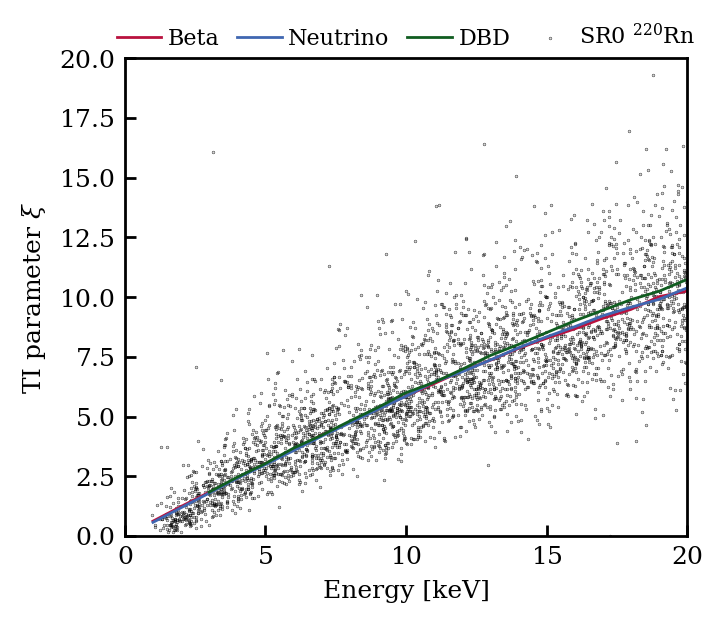

In [39]:
plt.figure(figsize=(3.5, 3))

for item in plot_kwargs:
    plt.plot(item['energy'], r_to_ti(item['recomb']), label=item['label'], color=item['color'])

# plt.plot(energy, sr0_fit_ti(energy), label='SR0 fitting', alpha=0.3)
plt.scatter(data['e_ces'], data['ti'], label=r'SR0 $^{220}$Rn', s=0.1, color='k')

plt.xlim(0, 20)
plt.ylim(0, 20)
plt.xlabel('Energy [keV]')
plt.ylabel(r'TI parameter $\xi$')
plt.legend(ncols=4)
plt.savefig('non_beta.svg')
plt.savefig('non_beta.png', dpi=300)
plt.show()

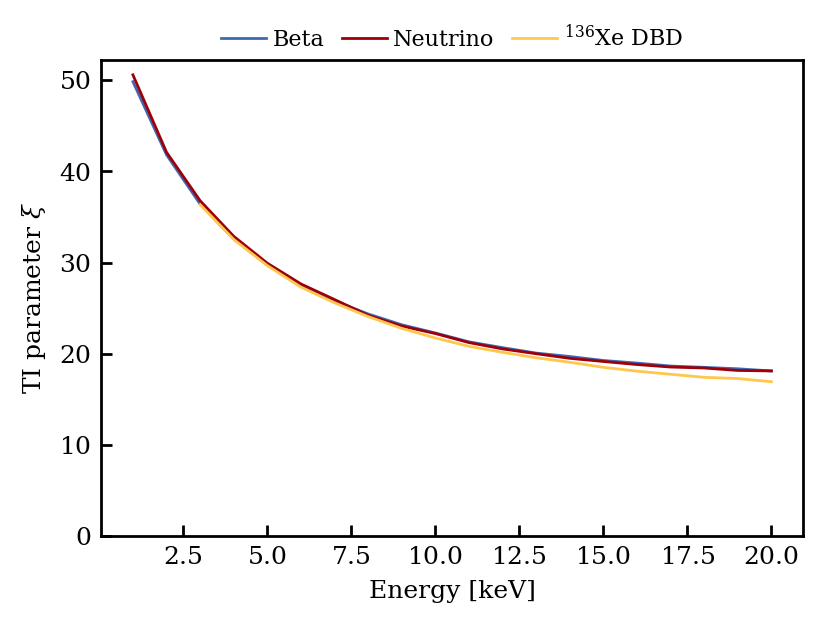

In [28]:
plt.figure(figsize=(4, 3))

r_to_qy = lambda r: 1 / w * 1 / (1 + nex_ni_ratio) * (1 - r)
for item in plot_kwargs:
    plt.plot(item['energy'], r_to_qy(item['recomb']), label=item['label'], color=item['color'])

# plt.plot(energy, sr0_fit_ti(energy), label='SR0 fitting', alpha=0.3)
plt.scatter(data['e_ces'], data['cs2']/g2, label=r'SR0 $^{220}$Rn', s=0.1, color='k')

plt.xlim(0, 20)
plt.ylim(0, None)
plt.xlabel('Energy [keV]')
plt.ylabel(r'TI parameter $\xi$')
plt.legend(ncols=4)
plt.show()